# Titanic Survival Prediction

This notebook explores the Titanic dataset to uncover patterns related to passenger survival.
The goal is to prepare features that can later be used in a classification model.

We investigate relationships between passenger attributes (like sex, age, fare, class) and survival outcome.

The analysis includes:
- Data cleaning & feature extraction
- Exploratory visualizations
- Transformations (e.g., log-transform, binning)
- Interpretation of survival patterns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load Data & Initial Inspection

We start by loading the dataset and checking for missing values, data types, and a basic statistical overview.

In [2]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.dropna().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

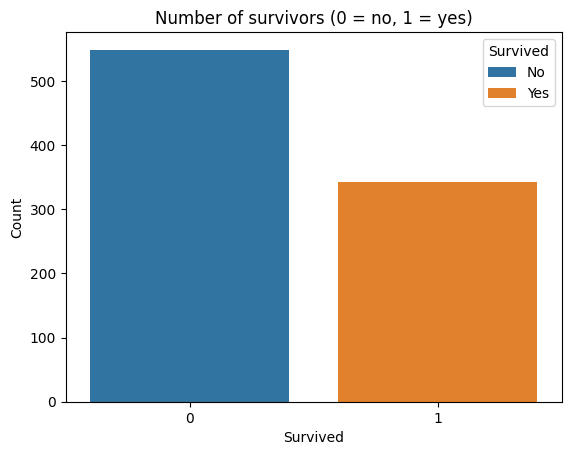

In [5]:
sns.countplot(data=df, x="Survived", hue="Survived")
plt.title("Number of survivors (0 = no, 1 = yes)")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

## Exploratory Data Analysis (EDA)

We explore how various passenger features relate to survival. This helps identify useful features and noisy ones.

### Survival by Sex and Age

These plots show a clear difference: women had a much higher survival rate than men and children were more likely to survive than adults, consistent with the "women and children first" evacuation principle.

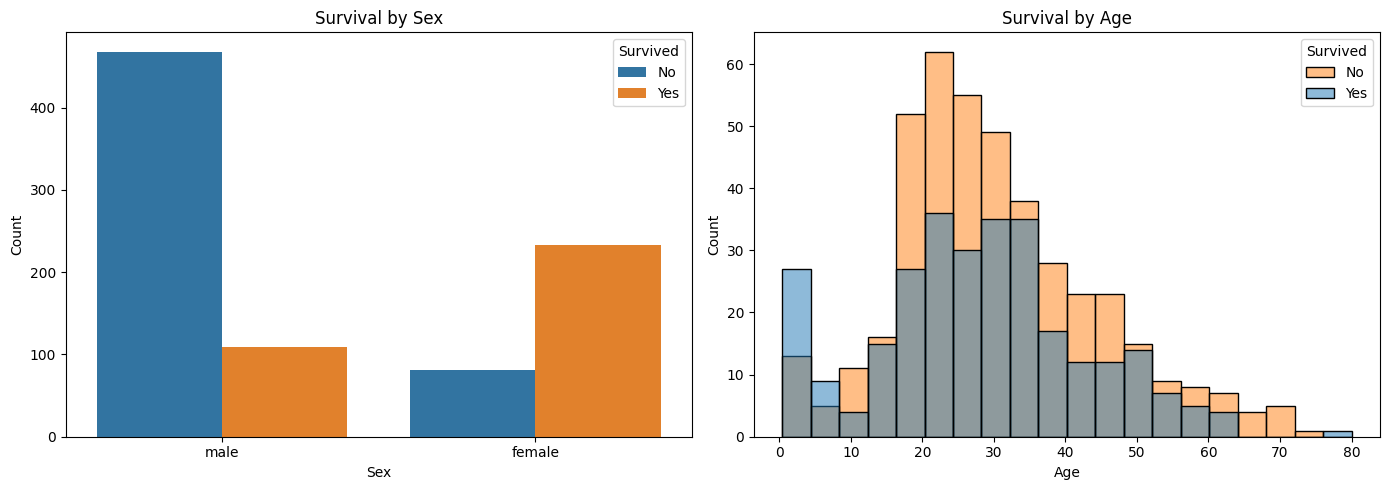

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ignore this
hue_order = [0, 1]
hue_order_2 = [1, 0]

sns.countplot(data=df, x="Sex", hue="Survived", ax=axes[0], hue_order=hue_order)
axes[0].set_title("Survival by Sex")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")
axes[0].legend(title="Survived", labels=["No", "Yes"])

sns.histplot(data=df, x="Age", hue="Survived", bins=20, ax=axes[1], hue_order=hue_order_2)
axes[1].set_title("Survival by Age")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")
axes[1].legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

### Survival by Passenger Class

Higher-class passengers had significantly better survival chances. This likely reflects access to lifeboats and cabin location.

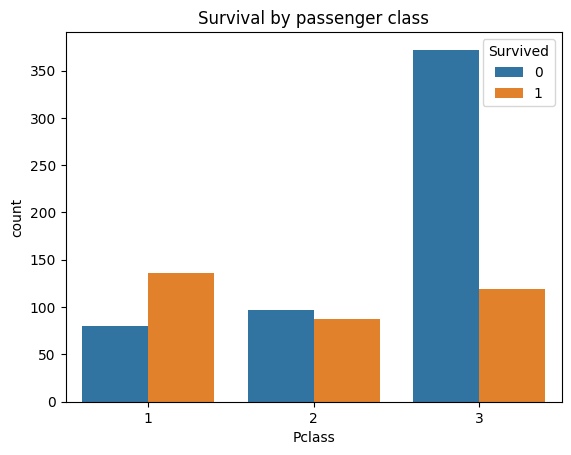

In [7]:
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Survival by passenger class")
plt.show()

### Cabin-Based Features

We extract the deck (A–G) and the numeric part of the cabin.  
**Deck** appears to be a strong signal: passengers on higher decks had better survival chances, likely due to proximity to lifeboats.

**Cabin number**, on the other hand, shows no clear pattern in relation to survival. This suggests that its position along the length of the ship (which the number might represent) had little or no influence on the outcome — or that the numbering system was too inconsistent to be useful.

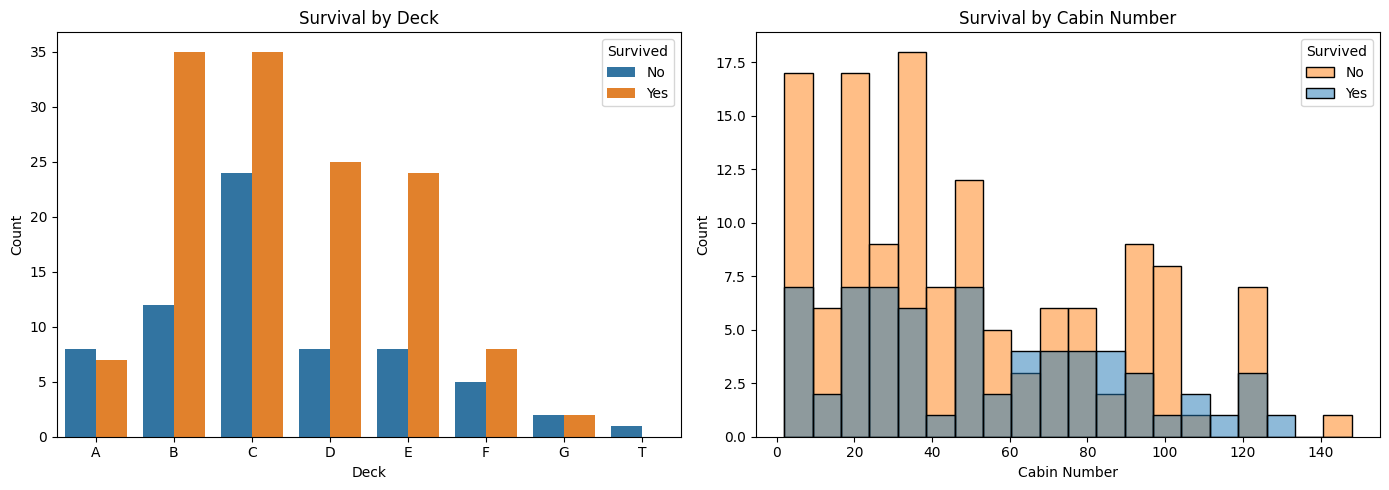

In [8]:
df["Deck"] = df["Cabin"].str.extract(r"([A-Za-z])")
df["CabinNumber"] = df["Cabin"].str.extract(r"(\d+)").astype("float")

hue_order = [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(
    data=df,
    x="Deck",
    hue="Survived",
    order=sorted(df["Deck"].dropna().unique()),
    hue_order=hue_order,
    ax=axes[0]
)
axes[0].set_title("Survival by Deck")
axes[0].set_xlabel("Deck")
axes[0].set_ylabel("Count")
axes[0].legend(title="Survived", labels=["No", "Yes"])

sns.histplot(
    data=df,
    x="CabinNumber",
    hue="Survived",
    bins=20,
    hue_order=hue_order,
    ax=axes[1]
)
axes[1].set_title("Survival by Cabin Number")
axes[1].set_xlabel("Cabin Number")
axes[1].set_ylabel("Count")
axes[1].legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

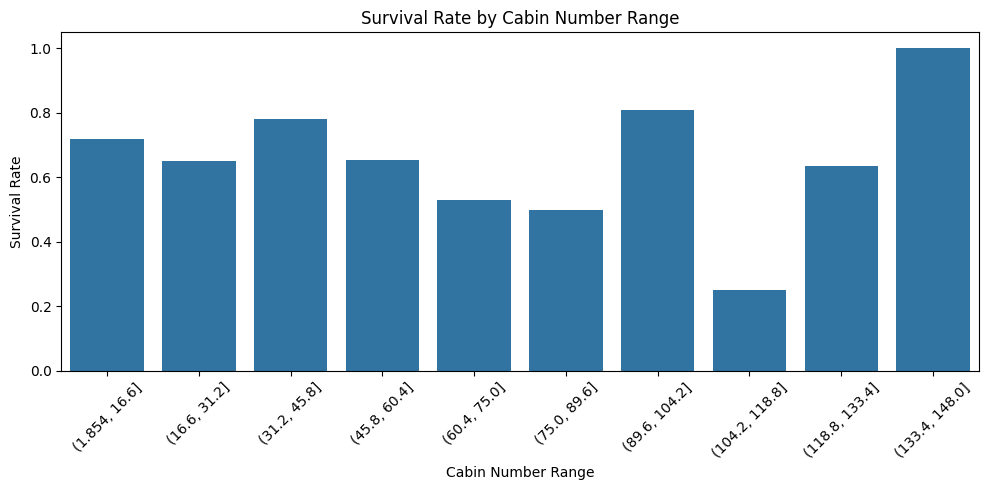

In [9]:
df["CabinBin"] = pd.cut(df["CabinNumber"], bins=10)
survival_rate = df.groupby("CabinBin", observed=False)["Survived"].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x="CabinBin", y="Survived", data=survival_rate)
plt.xticks(rotation=45)
plt.title("Survival Rate by Cabin Number Range")
plt.ylabel("Survival Rate")
plt.xlabel("Cabin Number Range")
plt.tight_layout()
plt.show()

### Family-Based Features: SibSp and Parch

These plots show the relationship between family structure and survival.

- **SibSp** counts siblings and spouses aboard.
- **Parch** counts parents and children aboard.

We observe that passengers with small families (1–2 relatives aboard) had better survival rates.  
In contrast, those traveling alone or in large groups (3+) were less likely to survive — possibly due to separation or difficulty evacuating together.

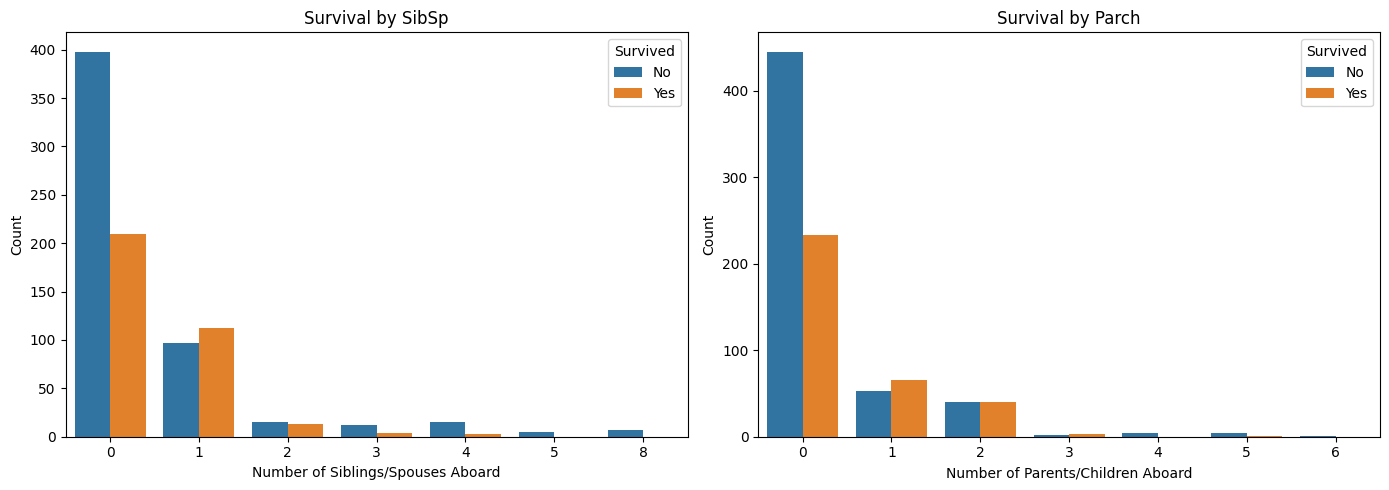

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x="SibSp", hue="Survived", ax=axes[0])
axes[0].set_title("Survival by SibSp")
axes[0].set_xlabel("Number of Siblings/Spouses Aboard")
axes[0].set_ylabel("Count")
axes[0].legend(title="Survived", labels=["No", "Yes"])

sns.countplot(data=df, x="Parch", hue="Survived", ax=axes[1])
axes[1].set_title("Survival by Parch")
axes[1].set_xlabel("Number of Parents/Children Aboard")
axes[1].set_ylabel("Count")
axes[1].legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

### Combined Feature: Family Size

To better capture the passenger’s social context, we combine `SibSp` and `Parch` into a new feature: **FamilySize**.

This includes all immediate family members aboard (siblings, spouses, parents, children) plus the passenger themself.

We observe that:
- Passengers with small families (2–4 people total) had the **highest survival rates**
- Those who were **alone (FamilySize = 1)** or in **large families (5+)** had **lower chances of survival**

This suggests that being with a few close relatives may have helped during evacuation, while being alone or in a big group could have made it harder to escape.

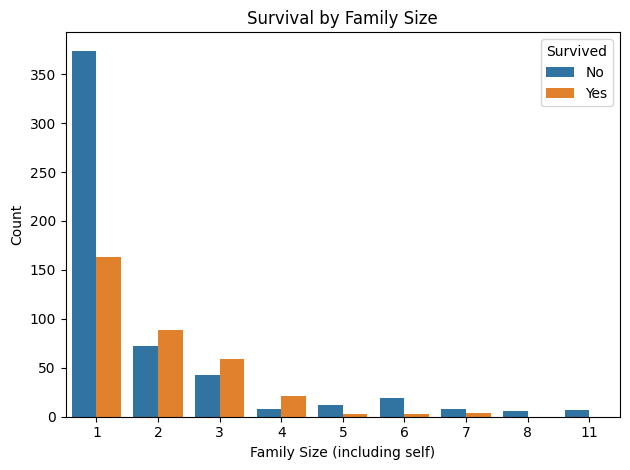

In [11]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

sns.countplot(data=df, x="FamilySize", hue="Survived")
plt.title("Survival by Family Size")
plt.xlabel("Family Size (including self)")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

### Fare Analysis and Transformation

Ticket fare varies widely across passengers, with a few extreme outliers (e.g., above £300).  
To visualize this without distortion, we zoom into the lower fare range:

- The plot shows that most passengers paid less than £100.
- There appears to be a weak tendency for higher-paying passengers to survive more often.

To better handle the skewed distribution, we apply a **logarithmic transformation** to the `Fare` variable.

- The left plot below shows the log-transformed fare distribution by survival.
- The right plot shows the **survival rate** per log-fare bin.

We observe that passengers who paid higher fares generally had better survival chances — likely reflecting class and cabin quality.

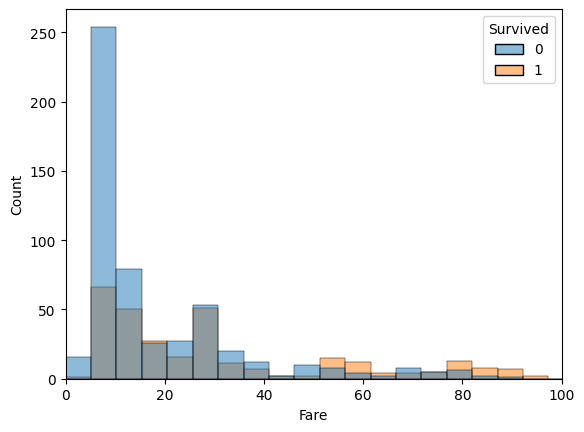

In [12]:
sns.histplot(data=df, x='Fare', bins=100, hue='Survived')
plt.xlim(0,100)
plt.show()

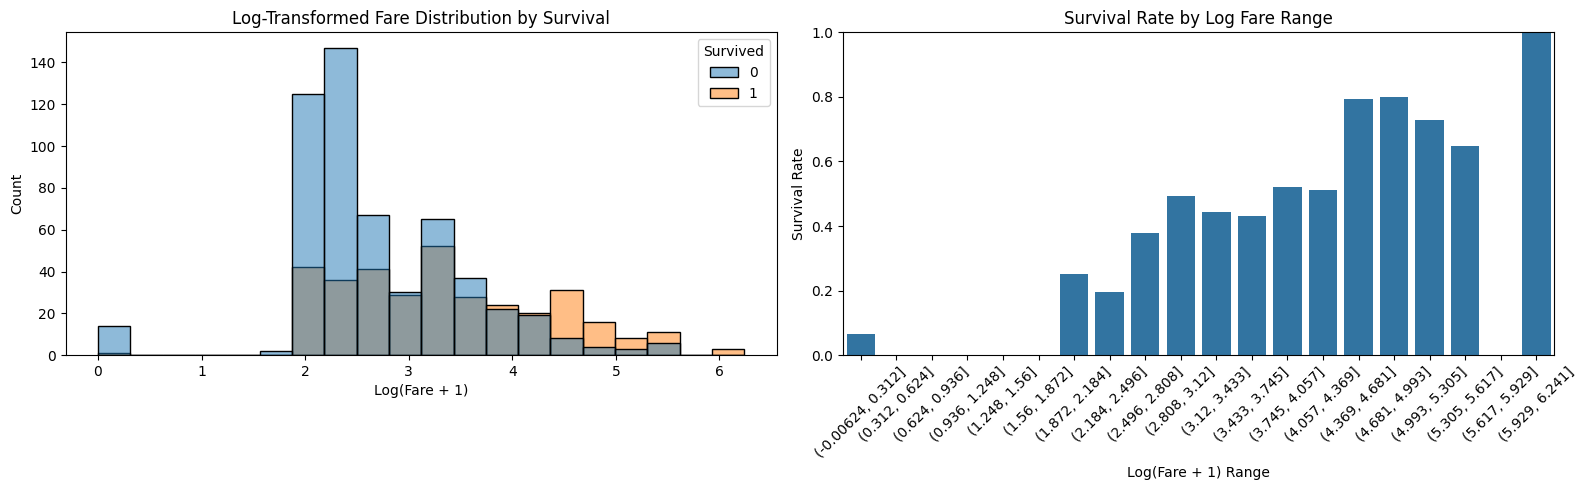

In [13]:
df['LogFare'] = np.log1p(df['Fare'])
df["LogFareBin"] = pd.cut(df["LogFare"], bins=20)
survival_rate = df.groupby("LogFareBin", observed=True)["Survived"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(data=df, x='LogFare', bins=20, hue='Survived', ax=axes[0])
axes[0].set_title("Log-Transformed Fare Distribution by Survival")
axes[0].set_xlabel("Log(Fare + 1)")
axes[0].set_ylabel("Count")

sns.barplot(x="LogFareBin", y="Survived", data=survival_rate, ax=axes[1])
axes[1].set_title("Survival Rate by Log Fare Range")
axes[1].set_xlabel("Log(Fare + 1) Range")
axes[1].set_ylabel("Survival Rate")
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Survival by Embarkation Port

This plot shows average survival rates by embarkation port:

- **C (Cherbourg)** has the highest survival rate, which aligns with the fact that many first-class passengers boarded there.
- **Q (Queenstown)** and **S (Southampton)** had lower survival rates on average.

This suggests that the port of embarkation may indirectly reflect passenger class or socio-economic background, and thus survival probability.

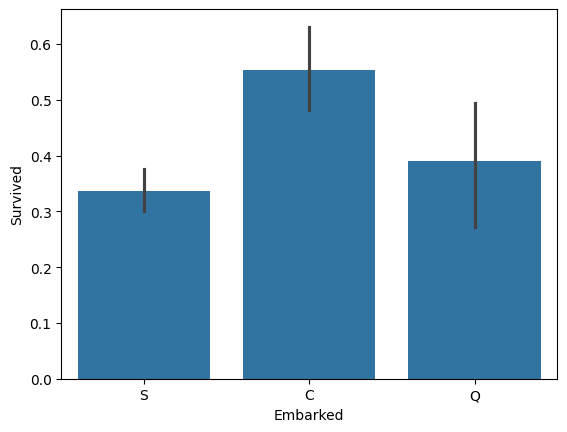

In [14]:
sns.barplot(data=df, x='Embarked', y='Survived')
plt.show()

### Embarkation Port and Socioeconomic Signals

To better understand why survival rates differ by embarkation port, we explore how `Embarked` relates to passenger class and fare.

- The **class distribution** shows that many 1st class passengers boarded at **Cherbourg (C)**, while **Southampton (S)** had more 3rd class passengers.
- The **fare distribution** confirms this: passengers from Cherbourg paid higher fares on average.

This suggests that `Embarked` is a proxy for **class and wealth**, which are key factors in survival likelihood.

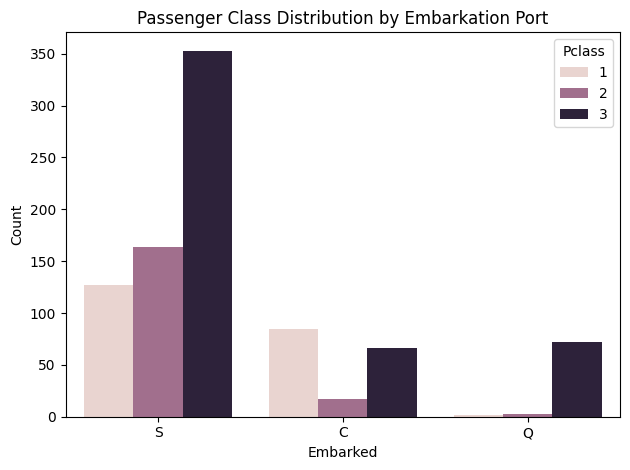

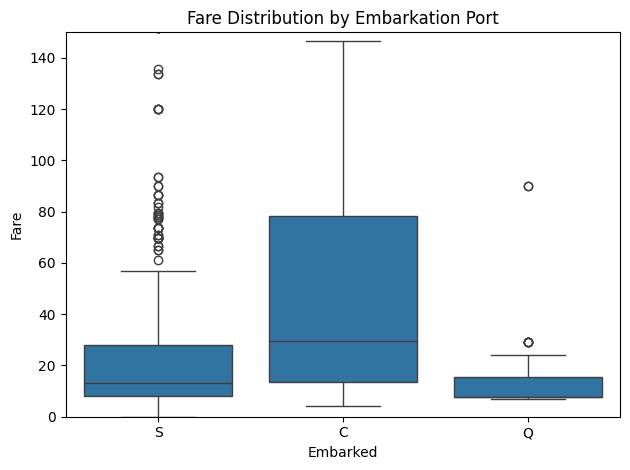

In [15]:
sns.countplot(data=df, x="Embarked", hue="Pclass")
plt.title("Passenger Class Distribution by Embarkation Port")
plt.xlabel("Embarked")
plt.ylabel("Count")
plt.legend(title="Pclass")
plt.tight_layout()
plt.show()

sns.boxplot(data=df, x="Embarked", y="Fare")
plt.title("Fare Distribution by Embarkation Port")
plt.xlabel("Embarked")
plt.ylabel("Fare")
plt.ylim(0, 150)
plt.tight_layout()
plt.show()

## ✅ EDA Summary & Next Steps

In this notebook, we explored key relationships in the Titanic dataset related to passenger survival.

Notable findings include:
- **Sex** and **Pclass** are strong predictors of survival.
- **Fare** and **Deck** show clear patterns, especially after transformation.
- **FamilySize** reveals that small groups had higher survival chances.
- Some variables, like **CabinNumber**, show little usable signal.

### Next Steps:
In the next phase, we will:
- Prepare a clean feature set
- Encode categorical variables
- Train and evaluate a classification model (e.g., Logistic Regression, Random Forest)
- Compare performance using cross-validation and metrics like accuracy, F1-score, and ROC-AUC

In [16]:
df.to_csv("titanic_processed_train.csv", index=False)